In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


In [11]:
base = VGG16(
    weights="vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",
    include_top=False,
    input_shape=(64,64,3)
)

In [4]:

# ---- Freeze base model ----
for layer in base.layers:
    layer.trainable = False


In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load CSVs
train = pd.read_csv("mnist_train.csv")
test = pd.read_csv("mnist_test.csv")

# Separate features and labels, convert to NumPy
X_train = train.drop(columns=['label']).values
y_train = train['label'].values

X_test = test.drop(columns=['label']).values
y_test = test['label'].values

# Normalize
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Reshape for image format
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Convert to 3 channels (RGB)
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Resize for pretrained model
X_train = tf.image.resize(X_train, [64, 64]).numpy()
X_test = tf.image.resize(X_test, [64, 64]).numpy()

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define model (example with MobileNetV2 base)
base = tf.keras.applications.MobileNetV2(
    input_shape=(64, 64, 3),
    include_top=False,
    weights='imagenet'
)
base.trainable = False

model = Sequential([
    base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

# Compile
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=64)


/var/folders/50/k1fc46tx35x2tnh0g1fhdbb00000gn/T/ipykernel_34341/485481740.py:41: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.8333 - loss: 0.5208 - val_accuracy: 0.9436 - val_loss: 0.1772
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.9332 - loss: 0.2079 - val_accuracy: 0.9488 - val_loss: 0.1541
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.9479 - loss: 0.1658 - val_accuracy: 0.9503 - val_loss: 0.1564
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.9563 - loss: 0.1394 - val_accuracy: 0.9603 - val_loss: 0.1262
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 43ms/step - accuracy: 0.9621 - loss: 0.1212 - val_accuracy: 0.9551 - val_loss: 0.1509


In [ ]:
model = Sequential([
    base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(102, activation='softmax')
])

# ---- Compile (train only new layers) ----
model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


# ---- Train ----
model.fit(X_train, validation_split = 0.2, epochs=5)


In [21]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9486 - loss: 0.1631
Validation Loss: 0.1485
Validation Accuracy: 0.9549


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

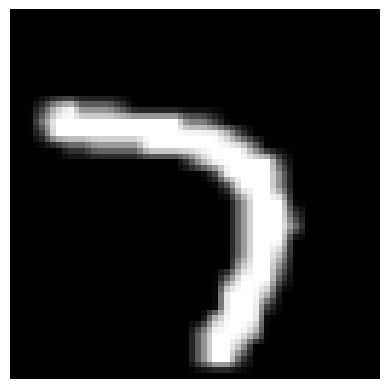

In [24]:
# X_test was already resized to (n, 64, 64, 3) earlier.
# Don't overwrite the existing 'img' variable (it is used in other cells).
# Display the 60th test image directly.
import matplotlib.pyplot as plt
plt.imshow(X_test[60])
plt.axis('off')

In [31]:
# Predict using the 60th test image (not the one-hot label).
# Add a batch dimension so the input shape is (1, 64, 64, 3).
output = model.predict(np.expand_dims(X_test[60], axis=0))
predicted_class = np.argmax(output, axis=1)[0]
print("Predicted class:", predicted_class)
print("True class:", np.argmax(y_test[60]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted class: 7
True class: 7


In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train','val'])
plt.show()

In [ ]:
# ------------------------------
# e) Fine-tune (optional) — unfreeze few deeper conv layers
# ------------------------------
for layer in base.layers[-4:]:   #a unfreeze last 4 conv blocks
    layer.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-5),
              metrics=['accuracy'])

history2 = model.fit(train_data,
                     validation_data=val_data,
                     epochs=5)